In [1]:
from tools import *

In [ ]:
np.random.seed(0)
nlp = spacy.load('en')#, disable=["tagger", "parser", "ner"])

# Getting started with data

In [2]:
source_path = '../input/shopee-product-matching'

In [3]:
train_df = pd.read_csv(f'{source_path}/train.csv')
test_df = pd.read_csv(f'{source_path}/test.csv')
sample_submission_df = pd.read_csv(f'{source_path}/sample_submission.csv')

In [4]:
print(f'Is there any NaN values?: {train_df.isnull().values.any()}')

Is there any NaN values?: False


In [5]:
train_df['image_path'] = train_df['image'].apply(lambda x: f"{source_path}/train_images/{x}")
test_df['image_path'] = test_df['image'].apply(lambda x: f"{source_path}/test_images/{x}")

In [6]:
train_df['hash'] = train_df['image_phash'].apply(lambda x: bin(int(x, 16))[2:].zfill(64))
test_df['hash'] = train_df['image_phash'].apply(lambda x: bin(int(x, 16))[2:].zfill(64))

In [7]:
print(f'Trainset: {train_df.shape} \nTestset: {test_df.shape}')

Trainset: (34250, 7) 
Testset: (3, 6)


In [8]:
train_df.head()

posting_id                                 image       image_phash  \
0   train_129225211  0000a68812bc7e98c42888dfb1c07da0.jpg  94974f937d4c2433   
1  train_3386243561  00039780dfc94d01db8676fe789ecd05.jpg  af3f9460c2838f0f   
2  train_2288590299  000a190fdd715a2a36faed16e2c65df7.jpg  b94cb00ed3e50f78   
3  train_2406599165  00117e4fc239b1b641ff08340b429633.jpg  8514fc58eafea283   
4  train_3369186413  00136d1cf4edede0203f32f05f660588.jpg  a6f319f924ad708c   

                                               title  label_group  \
0                          Paper Bag Victoria Secret    249114794   
1  Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...   2937985045   
2        Maling TTS Canned Pork Luncheon Meat 397 gr   2395904891   
3  Daster Batik Lengan pendek - Motif Acak / Camp...   4093212188   
4                  Nescafe \xc3\x89clair Latte 220ml   3648931069   

                                          image_path  \
0  ../input/shopee-product-matching/train_images/...   
1  ../input/shopee-product-matching/train_images/...   
2  ../input/shopee-product-matching/train_images/...   
3  ../input/shopee-product-matching/train_images/...   
4  ../input/shopee-product-matching/train_images/...   

                                                hash  
0  1001010010010111010011111001001101111101010011...  
1  1010111100111111100101000110000011000010100000...  
2  1011100101001100101100000000111011010011111001...  
3  1000010100010100111111000101100011101010111111...  
4  1010011011110011000110011111100100100100101011...

In [9]:
test_df.head()

posting_id                                 image       image_phash  \
0  test_2255846744  0006c8e5462ae52167402bac1c2e916e.jpg  ecc292392dc7687a   
1  test_3588702337  0007585c4d0f932859339129f709bfdc.jpg  e9968f60d2699e2c   
2  test_4015706929  0008377d3662e83ef44e1881af38b879.jpg  ba81c17e3581cabe   

                                               title  \
0  Edufuntoys - CHARACTER PHONE ada lampu dan mus...   
1  (Beli 1 Free Spatula) Masker Komedo | Blackhea...   
2   READY Lemonilo Mie instant sehat kuah dan goreng   

                                          image_path  \
0  ../input/shopee-product-matching/test_images/0...   
1  ../input/shopee-product-matching/test_images/0...   
2  ../input/shopee-product-matching/test_images/0...   

                                                hash  
0  1001010010010111010011111001001101111101010011...  
1  1010111100111111100101000110000011000010100000...  
2  1011100101001100101100000000111011010011111001...

# Label Group

In [10]:
label_group_count = train_df.groupby(['label_group']).size().reset_index()
label_group_count.columns = ['label_group', 'count']
label_group_count.sort_values(by='count', ascending=False, inplace=True)
label_group_count

label_group  count
3041   1163569239     51
412     159351600     51
2606    994676122     51
8037   3113678103     51
9370   3627744656     51
...           ...    ...
6069   2357508171      2
6068   2357372960      2
6067   2357221297      2
6066   2355878351      2
5507   2141883596      2

[11014 rows x 2 columns]

In [11]:
print(f'No. of Duplicate label group: {train_df[train_df["label_group"].duplicated() == True].shape[0]}')
print(f"Minimum product under single label group: {label_group_count['count'].min()}\nMaximum product under single label group: {label_group_count['count'].max()}")

No. of Duplicate label group: 23236
Minimum product under single label group: 2
Maximum product under single label group: 51


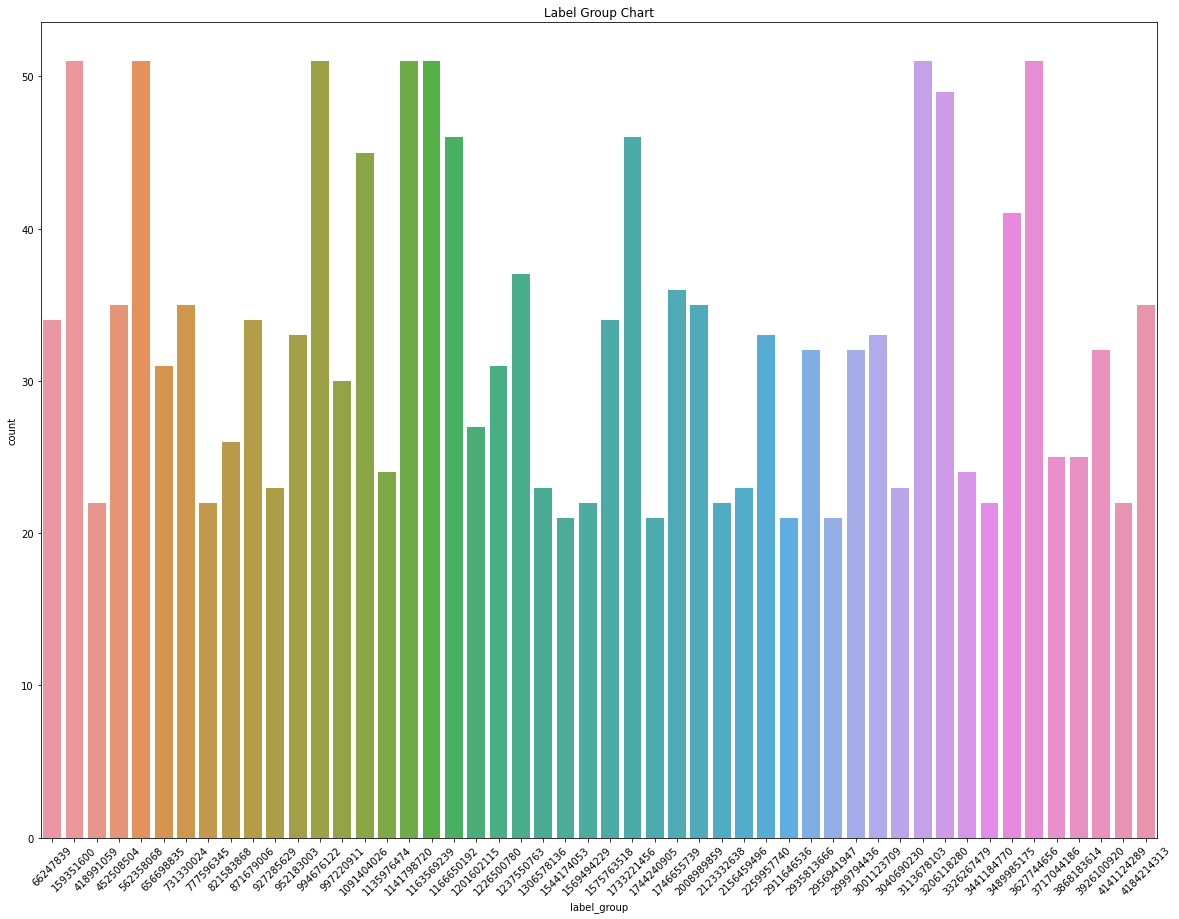

In [12]:
x, y = label_group_count['label_group'][:50], label_group_count['count'][:50]
plot_bar_chart(x, y, title='Label Group Chart')

Checking the similarity of image phash that falls under same group

In [13]:
train_df[train_df['label_group'] == 509010932]
hamming_distance('eab5c295966ac368', 'efc096b0d38e98c3')

30

Total images: 3


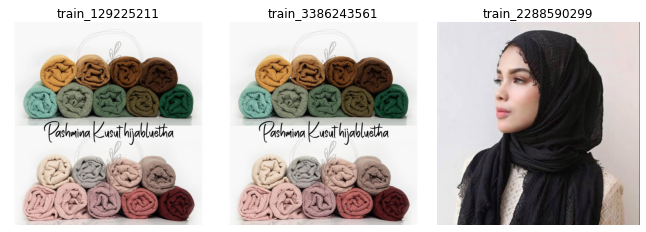

In [14]:
plot_images(train_df, 'label_group', 509010932)

Cannot rely on phash similarity, title similarity along with phash can be considered

# Images

In [15]:
image_count = train_df.groupby(['image']).size().reset_index()
image_count.columns = ['image', 'count']
image_count.sort_values(by='count', ascending=False, inplace=True)
image_count

image  count
1584   0cca4afba97e106abd0843ce72881ca4.jpg     15
25177  c739a327dbeca472089a5195e898cce4.jpg     13
4954   27a805a3f09f52abdc06c063a08e2803.jpg      9
18460  9320d7a2181b28e6a61317e8ca06ffea.jpg      9
11928  5ee62d13d49ea74cc3553f8ba5f6220d.jpg      9
...                                     ...    ...
11014  5790769fc7f053fabec611888bd8ddc8.jpg      1
11013  578f43eaa6d3f3829105525ad04c2b8b.jpg      1
11012  578f3332e0e70433874ba1160433a84a.jpg      1
11011  578e72051f7d23d2900869059c11cb7a.jpg      1
32411  ffffa0ab2ae542357671e96254fa7167.jpg      1

[32412 rows x 2 columns]

In [16]:
print(f'No. of Duplicate images: {train_df[train_df["image"].duplicated() == True].shape[0]}')

No. of Duplicate images: 1838


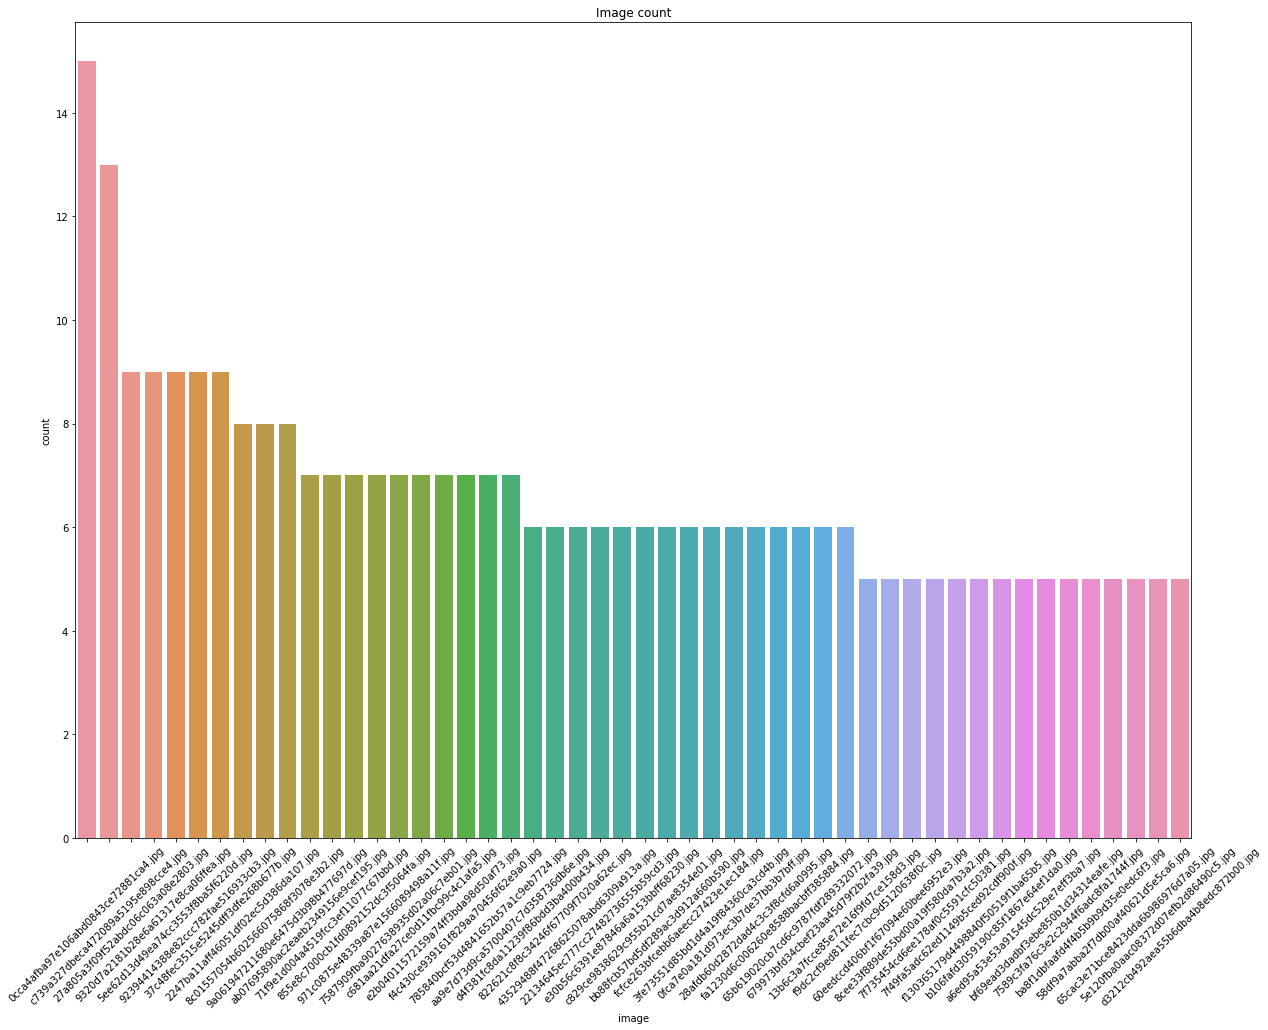

In [17]:
x, y = image_count['image'][:50], image_count['count'][:50]
plot_bar_chart(x, y, title='Image count')

Total images: 51


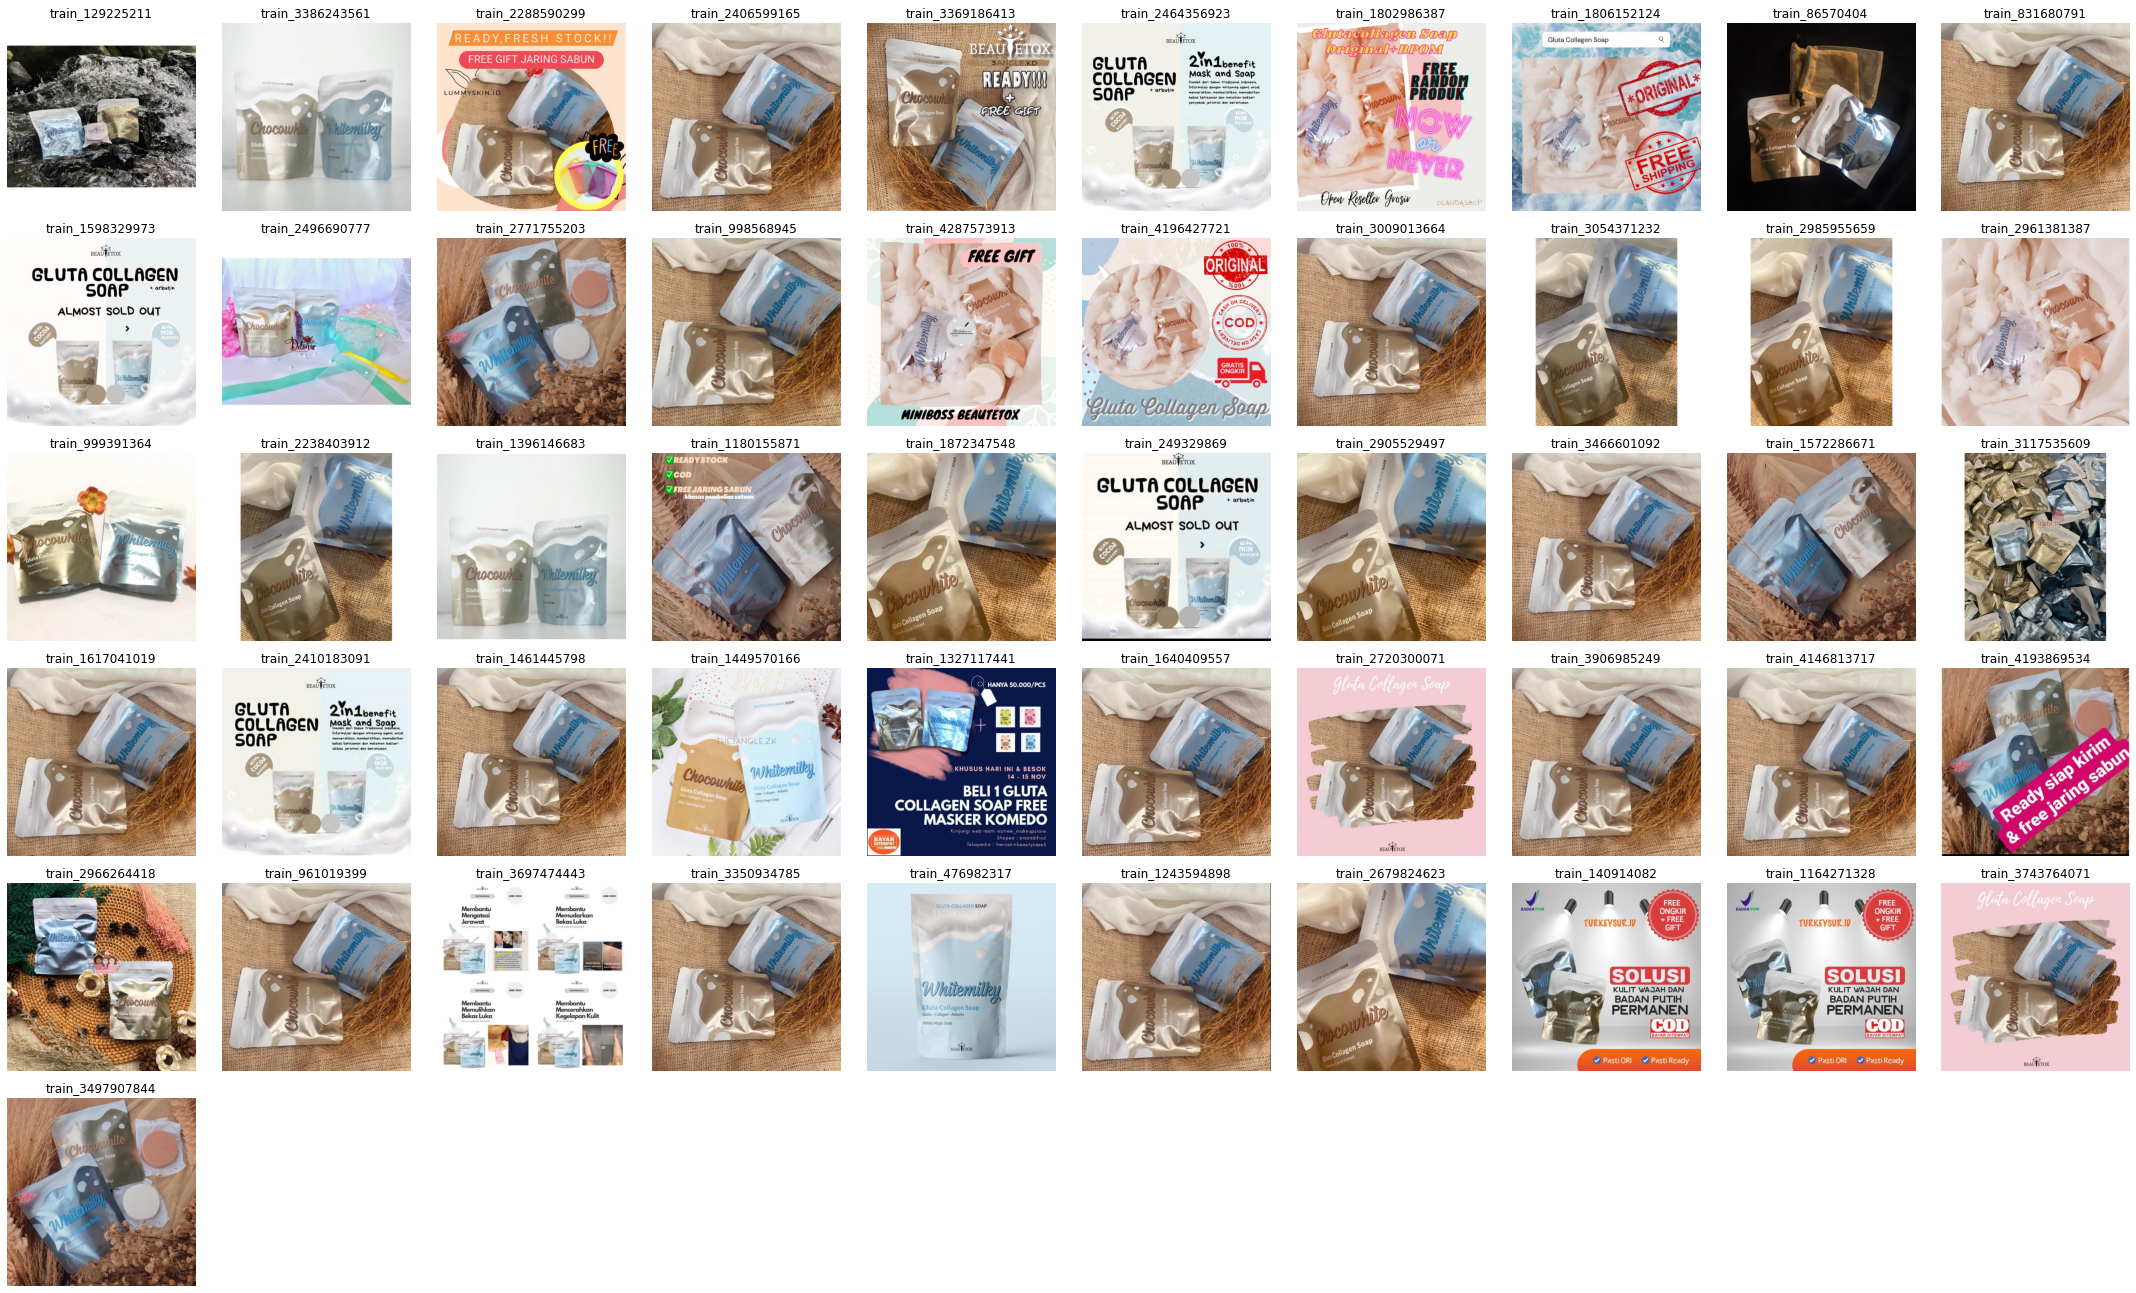

In [19]:
plot_images(train_df, 'label_group', 159351600)

# Image phash

In [20]:
phash_count = train_df.groupby(['image_phash']).size().reset_index()
phash_count.columns = ['image_phash', 'count']
phash_count.sort_values(by='count', ascending=False, inplace=True)
phash_count

image_phash  count
27584  fad28daa2ad05595     26
16476  d0c0ea37bd9acce0     20
12714  be12e12f9ec1e198     17
21189  e992966d4ba49761     16
26257  f6d98134b904b56b     16
...                 ...    ...
10119  b996c6cb9b82c266      1
10118  b996c6c5ce61c638      1
10117  b996c69992c7d330      1
10116  b996c669962dc986      1
28734  fffa9a21e185c094      1

[28735 rows x 2 columns]